# Welcome to Colab!

## Access popular AI models via Google-Colab-AI Without an API Key
All users have access to most popular LLMs via the `google-colab-ai` Python library, and paid users have access to a wider selection of models. For more details, refer to the [getting started with google colab ai](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb).



In [ ]:
# Run this AFTER loading your CDL
import numpy as np
import rasterio # Import rasterio

# Define the CDL path and load the data
cdl_path = "/content/drive/MyDrive/cdl_2024_brookings.tif"
try:
    with rasterio.open(cdl_path) as src:
        cdl = src.read(1)
    print(f"✓ CDL data loaded from {cdl_path}")
except Exception as e:
    print(f"!!!! ERROR loading CDL data from {cdl_path}: {e}")
    # Handle the error, maybe exit or set cdl to None
    cdl = None


# Check all unique CDL values in your study area
if cdl is not None:
    unique_cdl = np.unique(cdl)
    print("\nAll CDL values in your area:")
    print(unique_cdl)

    # Check wetland-specific codes
    wetland_codes_to_check = [87, 111, 190, 195]
    print("\nWetland codes present:")
    for code in wetland_codes_to_check:
        count = np.sum(cdl == code)
        if count > 0:
            area_ha = count * 100 / 10000
            print(f"  Code {code}: {count:,} pixels ({area_ha:.2f} ha)")
else:
    print("\nCDL data not available for analysis.")

✓ CDL data loaded from /content/drive/MyDrive/cdl_2024_brookings.tif

All CDL values in your area:
[  0   1   4   5  12  21  22  23  24  27  28  29  36  37  38  41  42  44
  47  53  58  59  60  61  68 111 121 122 123 124 131 141 142 143 152 176
 190 195 205]

Wetland codes present:
  Code 111: 58,731 pixels (587.31 ha)
  Code 190: 7 pixels (0.07 ha)
  Code 195: 83,945 pixels (839.45 ha)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with rasterio.open(cdl_path) as src:
    cdl_data = src.read(1)
    unique_codes = np.unique(cdl_data)
    print("CDL codes in your file:")
    for code in unique_codes:
        count = np.sum(cdl_data == code)
        print(f"  Code {code}: {count:,} pixels")

CDL codes in your file:
  Code 0: 40,083 pixels
  Code 1: 683,335 pixels
  Code 4: 1,592 pixels
  Code 5: 558,648 pixels
  Code 12: 4 pixels
  Code 21: 445 pixels
  Code 22: 53 pixels
  Code 23: 9,637 pixels
  Code 24: 841 pixels
  Code 27: 6,223 pixels
  Code 28: 12,518 pixels
  Code 29: 638 pixels
  Code 36: 60,279 pixels
  Code 37: 5,619 pixels
  Code 38: 62 pixels
  Code 41: 3 pixels
  Code 42: 438 pixels
  Code 44: 1,594 pixels
  Code 47: 45 pixels
  Code 53: 11 pixels
  Code 58: 4 pixels
  Code 59: 1 pixels
  Code 60: 10 pixels
  Code 61: 9,886 pixels
  Code 68: 720 pixels
  Code 111: 58,731 pixels
  Code 121: 86,578 pixels
  Code 122: 16,129 pixels
  Code 123: 11,442 pixels
  Code 124: 6,249 pixels
  Code 131: 2,941 pixels
  Code 141: 25,010 pixels
  Code 142: 716 pixels
  Code 143: 2,117 pixels
  Code 152: 24 pixels
  Code 176: 671,373 pixels
  Code 190: 7 pixels
  Code 195: 83,945 pixels
  Code 205: 1,489 pixels


In [ ]:
"""
================================================================================
WETLAND PERMANENCE CLASSIFICATION - FINAL CORRECTED VERSION
================================================================================
Brookings County, South Dakota - 2024
Method: NDWI (Gao) Coefficient of Variation Classification
Author: [Your Name]
Date: November 2024

IMPROVEMENTS IN THIS VERSION:
- Fixed CDL codes (removed outdated 83, 87; using only 111, 190, 195)
- Added edge buffering (2-pixel erosion) to reduce mixed pixel effects
- Improved patch counting (4-connectivity)
- Added data validation and quality checks
- Exports: Classification GeoTIFF, CV GeoTIFF, Excel workbook
- Enhanced error handling and reporting
================================================================================
"""

import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns
from scipy.ndimage import label, find_objects, binary_erosion
import pandas as pd
import warnings
import os
from datetime import datetime
from rasterio.warp import reproject, Resampling

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print("="*80)
print("WETLAND PERMANENCE CLASSIFICATION - FINAL CORRECTED VERSION")
print("Brookings County, South Dakota - 2024")
print("="*80)
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================================
# CONFIGURATION
# ============================================================================

base_path = "/content/drive/MyDrive/GIS-project/Colab_8Class_Unsupervised_Outputs/01_Mosaicked_Indices/"
cdl_path = "/content/drive/MyDrive/cdl_2024_brookings.tif"
output_path = "/content/drive/MyDrive/Wetland_Report_Final_Corrected/"

os.makedirs(output_path, exist_ok=True)
print(f"\n✓ Output directory: {output_path}")

# Analysis parameters
LOW_CV_THRESHOLD = 20
HIGH_CV_THRESHOLD = 50
MIN_PATCH_SIZE_HA = 0.01
EDGE_BUFFER_PIXELS = 2  # 2-pixel erosion to remove edge effects

print(f"\nAnalysis Parameters:")
print(f"  CV Thresholds: <{LOW_CV_THRESHOLD}% (Permanent), {LOW_CV_THRESHOLD}-{HIGH_CV_THRESHOLD}% (Vegetated), >{HIGH_CV_THRESHOLD}% (Seasonal)")
print(f"  Minimum patch size: {MIN_PATCH_SIZE_HA} ha")
print(f"  Edge buffer: {EDGE_BUFFER_PIXELS} pixels")

seasons = ['Spring', 'Summer', 'Fall']
ndwi_files = {
    'Spring': f"{base_path}NDWI_Spring_Full_10m.tif",
    'Summer': f"{base_path}NDWI_Summer_Full_10m.tif",
    'Fall': f"{base_path}NDWI_Fall_Full_10m.tif"
}

class_names = {
    1: 'Permanent Wetland',
    2: 'Vegetated Wetland',
    3: 'Seasonal Wetland'
}

class_names_full = {
    1: 'Permanent Wetland (Open Water)',
    2: 'Vegetated Wetland (Emergent)',
    3: 'Seasonal Wetland (Ephemeral)'
}

# Visualization colors
colors_map = ['#4169E1', '#FFA500', '#FF4500']  # Blue, Orange, Red
colors_pie = ['#4169E1', '#FFA500', '#FF4500']
colors_lines = ['#4169E1', '#FFA500', '#FF4500']
markers = ['o', '^', 's']

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=2)

# ============================================================================
# STEP 1: LOAD AND VALIDATE DATA
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING AND VALIDATING DATA")
print("="*80)

data = {'NDWI': {}}
metadata = None

# Load NDWI data and get target grid
try:
    with rasterio.open(ndwi_files['Spring']) as src:
        target_transform = src.transform
        target_width = src.width
        target_height = src.height
        target_crs = src.crs
        metadata = src.meta.copy()
        pixel_size = abs(src.transform[0])

    print(f"\nTarget Grid (from NDWI):")
    print(f"  Dimensions: {target_width} x {target_height} pixels")
    print(f"  Resolution: {pixel_size:.1f}m")
    print(f"  CRS: {target_crs}")

except Exception as e:
    print(f"❌ ERROR loading NDWI reference file: {e}")
    raise

# Load all NDWI layers
print(f"\nLoading NDWI data for {len(seasons)} seasons...")
for season, file_path in ndwi_files.items():
    try:
        with rasterio.open(file_path) as src:
            ndwi_data = src.read(1).astype(np.float32)
            ndwi_data[ndwi_data == src.nodata] = np.nan
            data['NDWI'][season] = ndwi_data

            # Validate NDWI range
            valid_data = ndwi_data[~np.isnan(ndwi_data)]
            min_val, max_val = np.min(valid_data), np.max(valid_data)
            print(f"  {season:8s}: Range [{min_val:+.3f}, {max_val:+.3f}] | Valid pixels: {len(valid_data):,}")

            if min_val < -1.5 or max_val > 1.5:
                print(f"    ⚠️  WARNING: NDWI values outside expected range [-1, +1]")

    except Exception as e:
        print(f"❌ ERROR loading {season} NDWI: {e}")
        raise

print("✓ All NDWI data loaded successfully")

# Load CDL
print(f"\nLoading CDL 2024...")
try:
    with rasterio.open(cdl_path) as src:
        cdl_30m = src.read(1)
        cdl_transform = src.transform
        cdl_crs = src.crs
        cdl_res = abs(src.transform[0])

    print(f"  Dimensions: {cdl_30m.shape[1]} x {cdl_30m.shape[0]} pixels")
    print(f"  Resolution: {cdl_res:.1f}m")

    # CRITICAL: Check what CDL codes are actually present
    unique_codes = np.unique(cdl_30m)
    print(f"\n  CDL codes present in file: {len(unique_codes)} unique values")

    # Check for wetland codes
    MODERN_WETLAND_CODES = {
        111: 'Open Water',
        190: 'Woody Wetlands',
        195: 'Herbaceous Wetlands'
    }

    DEPRECATED_CODES = {
        83: 'Water (deprecated)',
        87: 'Wetlands (deprecated)'
    }

    print(f"\n  Wetland code analysis:")
    wetland_found = False
    for code, name in MODERN_WETLAND_CODES.items():
        count = np.sum(cdl_30m == code)
        if count > 0:
            print(f"    ✓ Code {code} ({name}): {count:,} pixels")
            wetland_found = True
        else:
            print(f"    ✗ Code {code} ({name}): NOT FOUND")

    for code, name in DEPRECATED_CODES.items():
        count = np.sum(cdl_30m == code)
        if count > 0:
            print(f"    ⚠️  Code {code} ({name}): {count:,} pixels (SHOULD NOT BE USED)")

    if not wetland_found:
        print(f"\n    ❌ ERROR: No wetland codes found in CDL file!")
        print(f"    First 20 unique codes in file: {unique_codes[:20]}")
        raise ValueError("No wetland pixels detected in CDL")

    print("✓ CDL loaded successfully")

except Exception as e:
    print(f"❌ ERROR loading CDL: {e}")
    raise

# ============================================================================
# STEP 2: CREATE AND ALIGN WETLAND MASK (FIXED)
# ============================================================================
print("\n" + "="*80)
print("STEP 2: CREATING AND ALIGNING WETLAND MASK")
print("="*80)

# Use ONLY modern CDL codes (111, 190, 195)
WETLAND_CODES = {
    111: 'Open Water',
    190: 'Woody Wetlands',
    195: 'Herbaceous Wetlands'
}

print(f"Creating wetland mask using CDL codes: {list(WETLAND_CODES.keys())}")

# Create mask at 30m resolution
wetland_mask_30m = np.isin(cdl_30m, list(WETLAND_CODES.keys()))
wetland_pixels_30m = np.sum(wetland_mask_30m)
area_30m = wetland_pixels_30m * (cdl_res**2) / 10000  # Convert to ha

print(f"\nWetland mask at 30m resolution:")
print(f"  Pixels: {wetland_pixels_30m:,}")
print(f"  Area: {area_30m:.2f} ha")

# Reproject to 10m grid
print(f"\nReprojecting from 30m to 10m resolution...")
wetland_mask_10m = np.zeros((target_height, target_width), dtype=np.uint8)

reproject(
    source=wetland_mask_30m.astype(np.uint8),
    destination=wetland_mask_10m,
    src_transform=cdl_transform,
    src_crs=cdl_crs,
    dst_transform=target_transform,
    dst_crs=target_crs,
    resampling=Resampling.nearest,
    dst_nodata=0
)

wetland_mask_10m = wetland_mask_10m.astype(bool)
pixel_area_ha = (pixel_size**2) / 10000  # 10m x 10m = 100 m² = 0.01 ha

print(f"✓ Reprojection complete")
print(f"\nWetland mask at 10m resolution:")
print(f"  Pixels: {np.sum(wetland_mask_10m):,}")
print(f"  Area: {np.sum(wetland_mask_10m) * pixel_area_ha:.2f} ha")
print(f"  Pixel size: {pixel_area_ha:.4f} ha")

# Apply edge buffering to reduce mixed pixel effects
print(f"\nApplying {EDGE_BUFFER_PIXELS}-pixel erosion to remove edge effects...")
wetland_mask_original = wetland_mask_10m.copy()
structure = np.ones((3, 3))
wetland_mask_buffered = binary_erosion(wetland_mask_10m, structure=structure, iterations=EDGE_BUFFER_PIXELS)

pixels_removed = np.sum(wetland_mask_original) - np.sum(wetland_mask_buffered)
area_removed = pixels_removed * pixel_area_ha

print(f"  Pixels removed (edge effects): {pixels_removed:,}")
print(f"  Area removed: {area_removed:.2f} ha ({100*pixels_removed/np.sum(wetland_mask_original):.1f}%)")
print(f"  Final core wetland area: {np.sum(wetland_mask_buffered) * pixel_area_ha:.2f} ha")

# Use buffered mask for analysis
wetland_mask = wetland_mask_buffered
total_wetland_pixels = np.sum(wetland_mask)
total_wetland_area = total_wetland_pixels * pixel_area_ha

print(f"\n✓ Final wetland mask created")
print(f"  Total pixels: {total_wetland_pixels:,}")
print(f"  Total area: {total_wetland_area:.2f} ha")

# --- Figure 1: Wetland Mask ---
print("\n📊 Generating Figure 1: Wetland Mask...")
fig, ax = plt.subplots(figsize=(12, 10))
wetland_display = wetland_mask.astype(float)
wetland_display[~wetland_mask] = np.nan
ax.imshow(wetland_display, cmap='Blues', interpolation='nearest')
ax.set_title('Figure 1: Wetland Mask - Brookings County, SD\n(USDA CDL 2024, 2-pixel edge buffer applied)',
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')
textstr = (f'Total Area: {total_wetland_area:.2f} ha\n'
           f'Resolution: 10m\n'
           f'CDL Codes: 111, 190, 195\n'
           f'Edge Buffer: {EDGE_BUFFER_PIXELS} pixels')
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props, family='monospace')
plt.tight_layout()
plt.savefig(f'{output_path}Figure1_Wetland_Mask.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close(fig)
print("✓ Saved: Figure1_Wetland_Mask.png")

# --- Export Wetland Mask as GeoTIFF ---
print("\n💾 Exporting Wetland Mask as GeoTIFF...")
mask_meta = metadata.copy()
mask_meta.update({'dtype': 'uint8', 'nodata': 0, 'count': 1})
mask_export = wetland_mask.astype(np.uint8)
# Set non-wetland pixels to nodata (0)
mask_export[~wetland_mask] = 0

with rasterio.open(f'{output_path}Wetland_Mask.tif', 'w', **mask_meta) as dst:
    dst.write(mask_export, 1)
print("✓ Saved: Wetland_Mask.tif")


# ============================================================================
# STEP 3: CALCULATE COEFFICIENT OF VARIATION (CV)
# ============================================================================
print("\n" + "="*80)
print("STEP 3: CALCULATING COEFFICIENT OF VARIATION")
print("="*80)

# Stack seasonal NDWI
ndwi_stack = np.stack([data['NDWI'][s] for s in seasons], axis=0)

# Calculate statistics
mean_ndwi = np.nanmean(ndwi_stack, axis=0)
std_ndwi = np.nanstd(ndwi_stack, axis=0)

# CV = (std / |mean|) * 100
# Use absolute value to handle negative NDWI (Gao index)
with np.errstate(divide='ignore', invalid='ignore'):
    cv_map = np.divide(std_ndwi, np.abs(mean_ndwi),
                       out=np.full_like(mean_ndwi, np.nan),
                       where=(mean_ndwi != 0)) * 100

# Apply wetland mask
cv_wetlands = cv_map.copy()
cv_wetlands[~wetland_mask] = np.nan

# Calculate CV statistics
cv_valid = cv_wetlands[~np.isnan(cv_wetlands)]
print(f"\nCV Statistics (wetland pixels only):")
print(f"  Valid pixels: {len(cv_valid):,}")
print(f"  Min CV: {np.min(cv_valid):.1f}%")
print(f"  Max CV: {np.max(cv_valid):.1f}%")
print(f"  Mean CV: {np.mean(cv_valid):.1f}%")
print(f"  Median CV: {np.median(cv_valid):.1f}%")
print(f"  25th percentile: {np.percentile(cv_valid, 25):.1f}%")
print(f"  75th percentile: {np.percentile(cv_valid, 75):.1f}%")

print("✓ CV calculated successfully")

# --- Figure 2: CV Map ---
print("\n📊 Generating Figure 2: CV Map...")
fig, ax = plt.subplots(figsize=(12, 10))
cv_colors = ['#006837', '#a6d96a', '#ffffbf', '#fdae61', '#d7191c']
cmap_cv = mcolors.LinearSegmentedColormap.from_list('cv_cmap', cv_colors, N=256)
im = ax.imshow(cv_wetlands, cmap=cmap_cv, vmin=0, vmax=100, interpolation='bilinear')
cbar = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.04, extend='max')
cbar.set_label('Coefficient of Variation (%)', fontsize=14, fontweight='bold')
cbar.ax.hlines([LOW_CV_THRESHOLD, HIGH_CV_THRESHOLD], 0, 1, colors='black', linewidth=2, linestyles='--')
ax.set_title('Figure 2: NDWI Coefficient of Variation (CV) Map\nBrookings County, SD',
             fontsize=14, fontweight='bold', pad=20)
ax.axis('off')
textstr = (f'CV Statistics:\n'
           f'Mean: {np.mean(cv_valid):.1f}%\n'
           f'Median: {np.median(cv_valid):.1f}%\n'
           f'Range: [{np.min(cv_valid):.1f}%, {np.max(cv_valid):.1f}%]\n'
           f'Valid Pixels: {len(cv_valid):,}')
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props, family='monospace')
plt.tight_layout()
plt.savefig(f'{output_path}Figure2_CV_Map.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close(fig)
print("✓ Saved: Figure2_CV_Map.png")

# Export CV as GeoTIFF
print("\n💾 Exporting CV map as GeoTIFF...")
cv_meta = metadata.copy()
cv_meta.update({'dtype': 'float32', 'nodata': -9999, 'count': 1})
cv_export = cv_map.copy()
cv_export[np.isnan(cv_export)] = -9999
with rasterio.open(f'{output_path}CV_Map.tif', 'w', **cv_meta) as dst:
    dst.write(cv_export.astype('float32'), 1)
print("✓ Saved: CV_Map.tif")

# ============================================================================
# STEP 4: CLASSIFY WETLAND PERMANENCE
# ============================================================================
print("\n" + "="*80)
print("STEP 4: CLASSIFYING WETLAND PERMANENCE")
print("="*80)

# Apply thresholds
classification = np.full_like(cv_wetlands, np.nan)
classification[cv_wetlands < LOW_CV_THRESHOLD] = 1  # Permanent
classification[(cv_wetlands >= LOW_CV_THRESHOLD) & (cv_wetlands < HIGH_CV_THRESHOLD)] = 2 # Vegetated
classification[cv_wetlands >= HIGH_CV_THRESHOLD] = 3      # Seasonal

# Initial classification counts
for class_val in [1, 2, 3]:
    count = np.sum(classification == class_val)
    print(f"  {class_names[class_val]:20s}: {count:,} pixels ({count * pixel_area_ha:.2f} ha)")

print("\n🧹 Cleaning classification (removing patches < {MIN_PATCH_SIZE_HA} ha)...")
classification_clean = classification.copy()

# Use 4-connectivity for more conservative patch counting
structure_4conn = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])

for class_val in [1, 2, 3]:
    class_mask = (classification == class_val)
    labeled, num_features = label(class_mask, structure=structure_4conn)

    patches_removed = 0
    area_removed = 0

    for patch_id in range(1, num_features + 1):
        patch_pixels = np.sum(labeled == patch_id)
        patch_area = patch_pixels * pixel_area_ha

        if patch_area < MIN_PATCH_SIZE_HA:
            classification_clean[labeled == patch_id] = np.nan
            patches_removed += 1
            area_removed += patch_area

    print(f"  {class_names[class_val]:20s}: Removed {patches_removed:,} patches ({area_removed:.2f} ha)")

print("✓ Classification complete")

# Final classification counts
total_classified_pixels = 0
print("\nFinal classification:")
for class_val in [1, 2, 3]:
    count = np.sum(classification_clean == class_val)
    total_classified_pixels += count
    area = count * pixel_area_ha
    print(f"  {class_names[class_val]:20s}: {count:,} pixels ({area:.2f} ha)")

print(f"  {'TOTAL':20s}: {total_classified_pixels:,} pixels ({total_classified_pixels * pixel_area_ha:.2f} ha)")

# --- Figure 3: Classification Map ---
print("\n📊 Generating Figure 3: Classification Map...")
fig, ax = plt.subplots(figsize=(12, 10))

class_display = np.full(classification_clean.shape + (3,), 0.95)
class_display[classification_clean == 1] = mcolors.to_rgb(colors_map[0])
class_display[classification_clean == 2] = mcolors.to_rgb(colors_map[1])
class_display[classification_clean == 3] = mcolors.to_rgb(colors_map[2])

ax.imshow(class_display, interpolation='nearest')
ax.set_title('Figure 3: Wetland Permanence Classification Map\nBrookings County, SD (NDWI CV Method)',
             fontsize=14, fontweight='bold', pad=20)
ax.axis('off')

legend_elements = [
    Patch(facecolor=colors_map[0], edgecolor='black',
          label=f'{class_names_full[1]} (CV < {LOW_CV_THRESHOLD}%)'),
    Patch(facecolor=colors_map[1], edgecolor='black',
          label=f'{class_names_full[2]} (CV {LOW_CV_THRESHOLD}-{HIGH_CV_THRESHOLD}%)'),
    Patch(facecolor=colors_map[2], edgecolor='black',
          label=f'{class_names_full[3]} (CV > {HIGH_CV_THRESHOLD}%)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11, framealpha=0.95,
         edgecolor='black', fancybox=True)

plt.tight_layout()
plt.savefig(f'{output_path}Figure3_Classification_Map.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close(fig)
print("✓ Saved: Figure3_Classification_Map.png")

# Export classification as GeoTIFF
print("\n💾 Exporting classification as GeoTIFF...")
class_meta = metadata.copy()
class_meta.update({'dtype': 'uint8', 'nodata': 0, 'count': 1})
class_export = classification_clean.copy()
class_export[np.isnan(class_export)] = 0
with rasterio.open(f'{output_path}Wetland_Classification.tif', 'w', **class_meta) as dst:
    dst.write(class_export.astype('uint8'), 1)
    # Write class names as metadata
    dst.update_tags(1,
                   class_1='Permanent Wetland',
                   class_2='Vegetated Wetland',
                   class_3='Seasonal Wetland')
print("✓ Saved: Wetland_Classification.tif")

# ============================================================================
# STEP 5: CALCULATE COMPREHENSIVE STATISTICS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: CALCULATING STATISTICS")
print("="*80)

# Area-based statistics
area_stats = {}
for class_val in [1, 2, 3]:
    count = np.sum(classification_clean == class_val)
    area_ha = count * pixel_area_ha
    pct = (count / total_classified_pixels) * 100
    area_stats[class_val] = {'count': count, 'area_ha': area_ha, 'pct': pct}

# Patch-based statistics (using 4-connectivity)
patch_stats = {}
for class_val in [1, 2, 3]:
    class_mask = (classification_clean == class_val)
    labeled_array, num_patches = label(class_mask, structure=structure_4conn)

    patch_sizes = []
    for patch_id in range(1, num_patches + 1):
        patch_pixels = np.sum(labeled_array == patch_id)
        patch_area_ha = patch_pixels * pixel_area_ha
        if patch_area_ha >= MIN_PATCH_SIZE_HA:
            patch_sizes.append(patch_area_ha)

    patch_stats[class_val] = {
        'num_patches': len(patch_sizes),
        'sizes': patch_sizes,
        'mean_size': np.mean(patch_sizes) if patch_sizes else 0,
        'median_size': np.median(patch_sizes) if patch_sizes else 0,
        'std_size': np.std(patch_sizes) if patch_sizes else 0,
        'min_size': np.min(patch_sizes) if patch_sizes else 0,
        'max_size': np.max(patch_sizes) if patch_sizes else 0
    }

    print(f"\n{class_names[class_val]}:")
    print(f"  Number of patches: {len(patch_sizes):,}")
    print(f"  Mean size: {patch_stats[class_val]['mean_size']:.4f} ha")
    print(f"  Median size: {patch_stats[class_val]['median_size']:.4f} ha")
    print(f"  Size range: [{patch_stats[class_val]['min_size']:.4f}, {patch_stats[class_val]['max_size']:.2f}] ha")

total_patches = sum([patch_stats[i]['num_patches'] for i in [1, 2, 3]])
print(f"\n✓ Total patches: {total_patches:,}")

# CV statistics by class
cv_stats_by_class = {}
for class_val in [1, 2, 3]:
    class_cv = cv_wetlands[classification_clean == class_val]
    class_cv = class_cv[~np.isnan(class_cv)]

    cv_stats_by_class[class_val] = {
        'mean': np.mean(class_cv),
        'median': np.median(class_cv),
        'std': np.std(class_cv),
        'min': np.min(class_cv),
        'max': np.max(class_cv),
        'q25': np.percentile(class_cv, 25),
        'q75': np.percentile(class_cv, 75)
    }

# --- Figure 4: Pie Charts ---
print("\n📊 Generating Figure 4: Pie Charts...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Area distribution
sizes_area = [area_stats[i]['area_ha'] for i in [1, 2, 3]]
labels_area = [f"{class_names[i]}\n{area_stats[i]['pct']:.1f}%" for i in [1, 2, 3]]
ax1.pie(sizes_area, labels=labels_area, colors=colors_pie, startangle=90,
       autopct='', textprops={'fontsize': 12, 'weight': 'bold'})
ax1.set_title(f'Wetland Area Distribution\nTotal: {total_classified_pixels * pixel_area_ha:.2f} ha',
             fontsize=16, fontweight='bold', pad=20)

# Patch distribution
sizes_patch = [patch_stats[i]['num_patches'] for i in [1, 2, 3]]
labels_patch = [f"{class_names[i]}\n{patch_stats[i]['num_patches']/total_patches*100:.1f}%" for i in [1, 2, 3]]
ax2.pie(sizes_patch, labels=labels_patch, colors=colors_pie, startangle=90,
       autopct='', textprops={'fontsize': 12, 'weight': 'bold'})
ax2.set_title(f'Wetland Patch Count Distribution\nTotal: {total_patches:,} patches',
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(f'{output_path}Figure4_Pie_Charts.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close(fig)
print("✓ Saved: Figure4_Pie_Charts.png")

# ============================================================================
# STEP 6: SEASONAL FINGERPRINT VALIDATION
# ============================================================================
print("\n" + "="*80)
print("STEP 6: SEASONAL FINGERPRINT VALIDATION")
print("="*80)

fingerprints = {}
for class_val in [1, 2, 3]:
    class_mask = (classification_clean == class_val)
    fingerprints[class_val] = {
        'spring': np.nanmean(data['NDWI']['Spring'][class_mask]),
        'summer': np.nanmean(data['NDWI']['Summer'][class_mask]),
        'fall': np.nanmean(data['NDWI']['Fall'][class_mask])
    }

    fp = fingerprints[class_val]
    values = [fp['spring'], fp['summer'], fp['fall']]
    range_val = max(values) - min(values)
    print(f"\n{class_names[class_val]}:")
    print(f"  Spring: {fp['spring']:+.4f}")
    print(f"  Summer: {fp['summer']:+.4f}")
    print(f"  Fall: {fp['fall']:+.4f}")
    print(f"  Range: {range_val:.4f}")

# --- Figure 7: Seasonal Fingerprint ---
print("\n📊 Generating Figure 7: Seasonal Fingerprint...")
fig, ax = plt.subplots(figsize=(12, 8))

season_positions = [0, 1, 2]
season_labels = ['Spring', 'Summer', 'Fall']

for idx, class_val in enumerate([1, 2, 3]):
    fp = fingerprints[class_val]
    values = [fp['spring'], fp['summer'], fp['fall']]
    ax.plot(season_positions, values, color=colors_lines[idx], marker=markers[idx],
            markersize=12, linewidth=3, label=class_names_full[class_val])

ax.set_xlabel('Season', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean NDWI (Gao)', fontsize=14, fontweight='bold')
ax.set_title('Figure 7: Seasonal NDWI Fingerprints by Class\n(Validation of CV Thresholds)',
             fontsize=16, fontweight='bold', pad=20)
ax.axhline(0, color='black', linestyle='--', linewidth=1, label='Water/Vegetation Boundary (0.0)')
ax.set_xticks(season_positions)
ax.set_xticklabels(season_labels, fontsize=12)
ax.legend(fontsize=12, loc='best', framealpha=0.95, edgecolor='black')
ax.grid(alpha=0.3, linestyle='--')

# Add interpretation text
interp_text = ('Permanent (Blue): Stably Negative (Open Water)\n'
               'Vegetated (Orange): Stably Positive (Vegetation)\n'
               'Seasonal (Red): Fluctuating (Ephemeral)')
ax.text(0.02, 0.98, interp_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(f'{output_path}Figure7_Seasonal_Fingerprint.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close(fig)
print("✓ Saved: Figure7_Seasonal_Fingerprint.png")

# ============================================================================
# STEP 7: ADDITIONAL ANALYSIS FIGURES
# ============================================================================
print("\n" + "="*80)
print("STEP 7: GENERATING ADDITIONAL ANALYSIS FIGURES")
print("="*80)

# --- Figure 6: Comprehensive Analysis (4 subplots) ---
print("\n📊 Generating Figure 6: Comprehensive Analysis...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot A: CV Distribution Histogram
ax = axes[0, 0]
cv_all = cv_wetlands[~np.isnan(cv_wetlands)]
# Filter extreme values for better visualization
cv_all_filtered = cv_all[cv_all <= 150]  # Remove extreme outliers

ax.hist(cv_all_filtered, bins=80, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axvline(LOW_CV_THRESHOLD, color='green', linestyle='--', linewidth=2.5,
          label=f'Permanent Threshold (CV = {LOW_CV_THRESHOLD}%)')
ax.axvline(HIGH_CV_THRESHOLD, color='red', linestyle='--', linewidth=2.5,
          label=f'Seasonal Threshold (CV = {HIGH_CV_THRESHOLD}%)')

ax.set_xlabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (pixels)', fontsize=12, fontweight='bold')
ax.set_title('(A) CV Distribution Across All Wetlands', fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10, loc='upper right')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0, 150)  # Cap at 150% for better viz

# Add statistics text
n_extreme = np.sum(cv_all > 150)
if n_extreme > 0:
    ax.text(0.98, 0.5, f'Note: {n_extreme:,} pixels\nwith CV > 150%\n(not shown)',
           transform=ax.transAxes, fontsize=9, va='center', ha='right',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))


# Subplot B: CV by Class (Boxplot)
ax = axes[0, 1]

# Prepare data with FILTERING of extreme values
cv_by_class = []
class_labels = []
for class_val in [1, 2, 3]:
    class_cv = cv_wetlands[classification_clean == class_val]
    class_cv = class_cv[~np.isnan(class_cv)]
    # FILTER: Cap CV at 150% to avoid extreme outliers
    class_cv_filtered = class_cv[class_cv <= 150]
    cv_by_class.append(class_cv_filtered)
    class_labels.append(class_names[class_val])

    # Report filtering
    n_filtered = len(class_cv) - len(class_cv_filtered)
    if n_filtered > 0:
        print(f"  {class_names[class_val]}: Filtered {n_filtered} extreme CV values (>{150}%)")


# Create boxplot with better styling
bp = ax.boxplot(cv_by_class, labels=class_labels,
                patch_artist=True,
                showmeans=True,
                showfliers=True,  # Show outliers but they're now capped at 150%
                widths=0.6,
                medianprops=dict(color='red', linewidth=2),
                meanprops=dict(marker='D', markerfacecolor='green', markersize=8),
                flierprops=dict(marker='o', markerfacecolor='gray', markersize=4, alpha=0.5))

# Color the boxes
box_colors = ['lightblue', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)


ax.set_ylabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
ax.set_title('(B) CV Distribution by Class (Filtered)', fontsize=13, fontweight='bold', pad=10)
ax.grid(alpha=0.3, axis='y', linestyle='--')
ax.set_ylim(0, 150)  # Set consistent y-axis

# Add legend for mean/median
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2, label='Median'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='green',
           markersize=8, label='Mean')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)


# Subplot C: Area vs Count Comparison
ax = axes[1, 0]

categories = ['Permanent', 'Vegetated', 'Seasonal']
area_pct = [area_stats[i]['pct'] for i in [1, 2, 3]]
patch_pct = [patch_stats[i]['num_patches']/total_patches*100 for i in [1, 2, 3]]

x = np.arange(len(categories))
width = 0.38

bars1 = ax.bar(x - width/2, area_pct, width, label='% of Total Area',
              color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, patch_pct, width, label='% of Total Patches',
              color='coral', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('(C) Area vs Patch Count Distribution', fontsize=13, fontweight='bold', pad=10)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(alpha=0.3, axis='y', linestyle='--')
ax.set_ylim(0, 65)

# Add value labels with better positioning
for i, (a, p) in enumerate(zip(area_pct, patch_pct)):
    ax.text(i - width/2, a + 1.5, f'{a:.1f}%', ha='center', va='bottom',
           fontsize=10, fontweight='bold')
    ax.text(i + width/2, p + 1.5, f'{p:.1f}%', ha='center', va='bottom',
           fontsize=10, fontweight='bold')


# Subplot D: Patch Size Distribution (Log scale)
ax = axes[1, 1]

all_sizes = []
all_labels = []
for class_val in [1, 2, 3]:
    sizes = patch_stats[class_val]['sizes']
    all_sizes.extend(np.log10(np.array(sizes) + 0.001))
    all_labels.extend([class_names[class_val]] * len(sizes))

sizes_df = pd.DataFrame({'Log10_Area': all_sizes, 'Class': all_labels})

# Plot histograms with better binning
for class_val, color in zip([1, 2, 3], colors_map):
    data = sizes_df[sizes_df['Class'] == class_names[class_val]]['Log10_Area']
    ax.hist(data, bins=45, alpha=0.6, label=class_names[class_val],
           color=color, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Log₁₀(Patch Area in ha)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (Number of Patches)', fontsize=12, fontweight='bold')
ax.set_title('(D) Patch Size Distribution by Class', fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10, loc='upper right')
ax.grid(alpha=0.3, linestyle='--')

# Add reference lines for key sizes
ax.axvline(np.log10(0.01), color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax.axvline(np.log10(0.1), color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax.axvline(np.log10(1.0), color='gray', linestyle=':', linewidth=1, alpha=0.7)

# Add size labels
size_labels = ['0.01 ha', '0.1 ha', '1 ha']
size_positions = [np.log10(0.01), np.log10(0.1), np.log10(1.0)]
for label, pos in zip(size_labels, size_positions):
    ax.text(pos, ax.get_ylim()[1]*0.95, label, rotation=90,
           va='top', ha='right', fontsize=8, alpha=0.7)


plt.tight_layout()
plt.savefig(f'{output_path}Figure6_Comprehensive_Analysis.png',
           dpi=300, bbox_inches='tight', facecolor='white')
plt.close(fig)
print("✓ Saved: Figure6_Comprehensive_Analysis.png")

# --- Figure 9: Bimodal Distribution ---
print("\n📊 Generating Figure 9: Bimodal Size Distribution...")
all_sizes = []
for class_val in [1, 2, 3]:
    all_sizes.extend(patch_stats[class_val]['sizes'])

all_sizes_log = np.log10(all_sizes)
all_sizes_log = all_sizes_log[np.isfinite(all_sizes_log)]

fig, ax = plt.subplots(figsize=(12, 7))
counts, bins, patches = ax.hist(all_sizes_log, bins=50, color='#3182bd', alpha=0.8, edgecolor='black')
ax.axvline(x=np.log10(0.03), color='red', linestyle='--', linewidth=2.5,
          label='Peak 1: Fragmented Systems (~0.03 ha)')
ax.axvline(x=np.log10(0.5), color='green', linestyle='--', linewidth=2.5,
          label='Peak 2: Contiguous Systems (~0.5 ha)')
ax.set_title('Figure 9: Bimodal Distribution of Patch Sizes (All Classes)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Wetland Size (Log10 ha)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (Number of Patches)', fontsize=12, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.4)

# Add text annotations
peak1_count = np.sum((all_sizes_log >= np.log10(0.01)) & (all_sizes_log < np.log10(0.1)))
peak2_count = np.sum((all_sizes_log >= np.log10(0.3)) & (all_sizes_log < np.log10(2)))
textstr = f'Small wetlands (<0.1 ha): {peak1_count:,}\nLarge wetlands (>0.3 ha): {peak2_count:,}'
ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props, family='monospace')

plt.tight_layout()
plt.savefig(f'{output_path}Figure9_Bimodal_Distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close(fig)
print("✓ Saved: Figure9_Bimodal_Distribution.png")


# ============================================================================
# STEP 8: CREATE STATISTICS TABLE AND EXPORT
# ============================================================================
print("\n" + "="*80)
print("STEP 8: CREATING STATISTICS TABLE AND EXCEL EXPORT")
print("="*80)

# Main statistics table
stats_table = []
for class_val in [1, 2, 3]:
    if class_val == 1:
        cv_thresh_str = f"CV < {LOW_CV_THRESHOLD}%"
    elif class_val == 2:
        cv_thresh_str = f"{LOW_CV_THRESHOLD}%-{HIGH_CV_THRESHOLD}%"
    else:
        cv_thresh_str = f"CV > {HIGH_CV_THRESHOLD}%"

    stats_table.append({
        'Class': class_names[class_val],
        'CV Threshold': cv_thresh_str,
        'Area (ha)': round(area_stats[class_val]['area_ha'], 2),
        'Area (%)': round(area_stats[class_val]['pct'], 1),
        'Patches': patch_stats[class_val]['num_patches'],
        'Patch (%)': round(patch_stats[class_val]['num_patches']/total_patches*100, 1),
        'Mean Size (ha)': round(patch_stats[class_val]['mean_size'], 4),
        'Median Size (ha)': round(patch_stats[class_val]['median_size'], 4)
    })

df_stats = pd.DataFrame(stats_table)

print("\n" + "="*80)
print("FINAL WETLAND CLASSIFICATION STATISTICS")
print("="*80)
print(df_stats.to_string(index=False))
print("="*80)

# Export to Excel with multiple sheets
excel_path = f'{output_path}Wetland_Statistics_Complete.xlsx'
print(f"\n💾 Creating Excel workbook: {excel_path}")

with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    # Sheet 1: Main Statistics
    df_stats.to_excel(writer, sheet_name='Classification Statistics', index=False)

    # Sheet 2: Seasonal Fingerprints
    fingerprint_data = []
    for season in ['spring', 'summer', 'fall']:
        row = {'Season': season.capitalize()}
        for class_val in [1, 2, 3]:
            row[class_names[class_val]] = round(fingerprints[class_val][season], 4)
        fingerprint_data.append(row)
    df_fingerprint = pd.DataFrame(fingerprint_data)
    df_fingerprint.to_excel(writer, sheet_name='Seasonal Fingerprints', index=False)

    # Sheet 3: CV Statistics by Class
    cv_stats_data = []
    for class_val in [1, 2, 3]:
        cv_stats_data.append({
            'Class': class_names[class_val],
            'Mean CV': round(cv_stats_by_class[class_val]['mean'], 2),
            'Median CV': round(cv_stats_by_class[class_val]['median'], 2),
            'Std Dev CV': round(cv_stats_by_class[class_val]['std'], 2),
            'Min CV': round(cv_stats_by_class[class_val]['min'], 2),
            'Max CV': round(cv_stats_by_class[class_val]['max'], 2),
            'Q25 CV': round(cv_stats_by_class[class_val]['q25'], 2),
            'Q75 CV': round(cv_stats_by_class[class_val]['q75'], 2)
        })
    df_cv_stats = pd.DataFrame(cv_stats_data)
    df_cv_stats.to_excel(writer, sheet_name='CV Statistics', index=False)

    # Sheet 4: Patch Size Statistics
    patch_size_data = []
    for class_val in [1, 2, 3]:
        patch_size_data.append({
            'Class': class_names[class_val],
            'Number of Patches': patch_stats[class_val]['num_patches'],
            'Mean Size (ha)': round(patch_stats[class_val]['mean_size'], 4),
            'Median Size (ha)': round(patch_stats[class_val]['median_size'], 4),
            'Std Dev (ha)': round(patch_stats[class_val]['std_size'], 4),
            'Min Size (ha)': round(patch_stats[class_val]['min_size'], 4),
            'Max Size (ha)': round(patch_stats[class_val]['max_size'], 4)
        })
    df_patch_size = pd.DataFrame(patch_size_data)
    df_patch_size.to_excel(writer, sheet_name='Patch Size Statistics', index=False)

    # Sheet 5: Metadata
    metadata_info = pd.DataFrame({
        'Parameter': [
            'Analysis Date',
            'Study Area',
            'NDWI Type',
            'Resolution',
            'Seasons Analyzed',
            'Total Wetland Area (ha)',
            'Total Classified Area (ha)',
            'Total Patches',
            'Permanent Threshold',
            'Seasonal Threshold',
            'CDL Codes Used',
            'CDL Year',
            'Edge Buffer (pixels)',
            'Minimum Patch Size (ha)',
            'Patch Connectivity'
        ],
        'Value': [
            datetime.now().strftime('%Y-%m-%d'),
            'Brookings County, South Dakota',
            'Gao NDWI (NIR-SWIR)',
            '10m',
            'Spring, Summer, Fall 2024',
            f'{total_wetland_area:.2f}',
            f'{total_classified_pixels * pixel_area_ha:.2f}',
            total_patches,
            f'CV < {LOW_CV_THRESHOLD}%',
            f'CV > {HIGH_CV_THRESHOLD}%',
            '111 (Open Water), 190 (Woody Wetlands), 195 (Herbaceous Wetlands)',
            '2024',
            EDGE_BUFFER_PIXELS,
            MIN_PATCH_SIZE_HA,
            '4-connectivity'
        ]
    })
    metadata_info.to_excel(writer, sheet_name='Metadata', index=False)

print("✓ Excel workbook created with 5 sheets:")
print("  - Classification Statistics")
print("  - Seasonal Fingerprints")
print("  - CV Statistics")
print("  - Patch Size Statistics")
print("  - Metadata")

# Save CSV version too
csv_path = f'{output_path}Wetland_Statistics_Summary.csv'
df_stats.to_csv(csv_path, index=False)
print(f"✓ CSV summary saved: {csv_path}")

# --- Generate Statistics Table Figure ---
print("\n📊 Generating Statistics Table Figure...")
fig, ax = plt.subplots(figsize=(16, 5))
ax.axis('tight')
ax.axis('off')

table_data = [df_stats.columns.tolist()] + df_stats.values.tolist()
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.20, 0.14, 0.10, 0.09, 0.10, 0.09, 0.14, 0.14])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

# Style header row
for i in range(len(df_stats.columns)):
    table[(0, i)].set_facecolor('#08519c')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style data rows
colors_rows = ['#c6dbef', '#fee0d2', '#fcbba1']
for i in range(1, len(table_data)):
    for j in range(len(df_stats.columns)):
        table[(i, j)].set_facecolor(colors_rows[i-1])
        table[(i, j)].set_text_props(weight='bold')

ax.set_title('Wetland Classification Statistics Summary\nBrookings County, SD - 2024',
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(f'{output_path}Figure_Statistics_Table.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close(fig)
print("✓ Saved: Figure_Statistics_Table.png")

# ============================================================================
# STEP 9: FINAL SUMMARY AND VALIDATION
# ============================================================================
print("\n" + "="*80)
print("FINAL ANALYSIS SUMMARY")
print("="*80)

print("\n📊 KEY FINDINGS:")
print(f"  Total wetland area analyzed: {total_wetland_area:.2f} ha")
print(f"  Total classified area: {total_classified_pixels * pixel_area_ha:.2f} ha")
print(f"  Total number of patches: {total_patches:,}")
print(f"\n  Dominant class by AREA: {class_names[max(area_stats, key=lambda x: area_stats[x]['pct'])]} ({max([area_stats[i]['pct'] for i in [1,2,3]]):.1f}%)")
print(f"  Dominant class by COUNT: {class_names[max(patch_stats, key=lambda x: patch_stats[x]['num_patches'])]} ({max([patch_stats[i]['num_patches']/total_patches*100 for i in [1,2,3]]):.1f}%)")

print("\n✅ DATA QUALITY CHECKS:")
# Check 1: Total percentages
total_area_pct = sum([area_stats[i]['pct'] for i in [1, 2, 3]])
total_patch_pct = sum([patch_stats[i]['num_patches']/total_patches*100 for i in [1, 2, 3]])
print(f"  Area percentages sum: {total_area_pct:.1f}% {'✓' if abs(total_area_pct - 100) < 0.5 else '⚠️'}")
print(f"  Patch percentages sum: {total_patch_pct:.1f}% {'✓' if abs(total_patch_pct - 100) < 0.5 else '⚠️'}")

# Check 2: NDWI fingerprint validation
for class_val in [1, 2, 3]:
    fp = fingerprints[class_val]
    values = [fp['spring'], fp['summer'], fp['fall']]
    range_val = max(values) - min(values)
    mean_val = np.mean(values)

    if class_val == 1:  # Permanent should be negative and stable
        check = mean_val < -0.1 and range_val < 0.1
        print(f"  {class_names[class_val]:20s}: Mean NDWI = {mean_val:+.3f}, Range = {range_val:.3f} {'✓' if check else '⚠️'}")
    elif class_val == 3:  # Seasonal should fluctuate
        check = range_val > 0.2
        print(f"  {class_names[class_val]:20s}: Mean NDWI = {mean_val:+.3f}, Range = {range_val:.3f} {'✓' if check else '⚠️'}")
    else:  # Vegetated
        check = mean_val > 0
        print(f"  {class_names[class_val]:20s}: Mean NDWI = {mean_val:+.3f}, Range = {range_val:.3f} {'✓' if check else '⚠️'}")

print("\n📁 OUTPUT FILES GENERATED:")
output_files = [
    "Figure1_Wetland_Mask.png",
    "Figure2_CV_Map.png",
    "Figure3_Classification_Map.png",
    "Figure4_Pie_Charts.png",
    "Figure6_Comprehensive_Analysis.png",
    "Figure7_Seasonal_Fingerprint.png",
    "Figure9_Bimodal_Distribution.png",
    "Figure_Statistics_Table.png",
    "Wetland_Mask.tif", # Added Wetland Mask GeoTIFF
    "CV_Map.tif",
    "Wetland_Classification.tif",
    "Wetland_Statistics_Complete.xlsx",
    "Wetland_Statistics_Summary.csv"
]

for filename in output_files:
    filepath = f"{output_path}{filename}"
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  ✓ {filename:40s} ({size_mb:.2f} MB)")
    else:
        print(f"  ✗ {filename:40s} (NOT FOUND)")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)
print(f"\nAll outputs saved to: {output_path}")
print(f"Analysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n🎉 Your wetland classification is ready for report writing!")
print("="*80)

WETLAND PERMANENCE CLASSIFICATION - FINAL CORRECTED VERSION
Brookings County, South Dakota - 2024
Analysis started: 2025-11-07 22:18:09

✓ Output directory: /content/drive/MyDrive/Wetland_Report_Final_Corrected/

Analysis Parameters:
  CV Thresholds: <20% (Permanent), 20-50% (Vegetated), >50% (Seasonal)
  Minimum patch size: 0.01 ha
  Edge buffer: 2 pixels

STEP 1: LOADING AND VALIDATING DATA

Target Grid (from NDWI):
  Dimensions: 5509 x 4018 pixels
  Resolution: 10.0m
  CRS: EPSG:32614

Loading NDWI data for 3 seasons...
  Spring  : Range [-1.000, +0.892] | Valid pixels: 20,853,914
  Summer  : Range [-0.884, +1.000] | Valid pixels: 20,853,914
  Fall    : Range [-0.879, +0.925] | Valid pixels: 20,853,914
✓ All NDWI data loaded successfully

Loading CDL 2024...
  Dimensions: 1808 x 1305 pixels
  Resolution: 30.0m

  CDL codes present in file: 39 unique values

  Wetland code analysis:
    ✓ Code 111 (Open Water): 58,731 pixels
    ✓ Code 190 (Woody Wetlands): 7 pixels
    ✓ Code 195 (H

In [ ]:
import numpy as np
import rasterio

# --- ASSUMED VARIABLES ---
# Make sure 'classification_clean' and 'metadata' are in your notebook's memory
# from the previous steps.
# 'classification_clean' is your numpy array with values 1, 2, 3
# 'metadata' is the variable you saved when you loaded the first NDWI file

# --- DEFINE OUTPUT PATH ---
# This is where your new map file will be saved
output_tif_path = "/content/drive/MyDrive/Wetland_Report_Figures_FINAL_v2/Wetland_Classification_Map.tif"

# --- UPDATE METADATA FOR EXPORT ---
# We need to copy the original metadata (projection, transform, etc.)
# but change the data type to integer and set the nodata value.
out_meta = metadata.copy()

# Update metadata for a single-band integer file
out_meta.update(
    dtype=rasterio.int16,  # Use int16 for classification (1, 2, 3)
    count=1,               # We are saving 1 band
    nodata=-9999           # A standard nodata value
)

# --- PREPARE THE DATA FOR SAVING ---
# Copy your classification and set all 'nan' (unclassified) pixels to -9999
classification_to_save = classification_clean.copy()
classification_to_save[np.isnan(classification_to_save)] = -9999

# --- WRITE THE GEOTIFF FILE ---
print(f"Saving GeoTIFF map to: {output_tif_path}")
with rasterio.open(output_tif_path, 'w', **out_meta) as dst:
    dst.write(classification_to_save.astype(rasterio.int16), 1)

print("✓ GeoTIFF map saved successfully!")

Saving GeoTIFF map to: /content/drive/MyDrive/Wetland_Report_Figures_FINAL_v2/Wetland_Classification_Map.tif
✓ GeoTIFF map saved successfully!


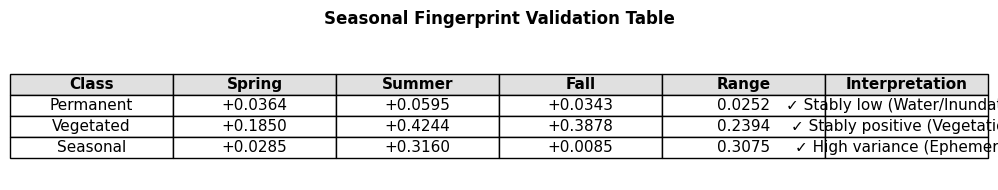

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Prepare your specific data
#    I have added the 'Interpretation' column based on the behavior of your data values
data = {
    'Class': ['Permanent', 'Vegetated', 'Seasonal'],
    'Spring': ['+0.0364', '+0.1850', '+0.0285'],
    'Summer': ['+0.0595', '+0.4244', '+0.3160'],
    'Fall':   ['+0.0343', '+0.3878', '+0.0085'],
    'Range':  ['0.0252', '0.2394', '0.3075'],
    'Interpretation': [
        '✓ Stably low (Water/Inundated)',  # Based on low values (~0.03)
        '✓ Stably positive (Vegetation)',   # Based on high values (~0.4)
        '✓ High variance (Ephemeral)'       # Based on large range (0.3)
    ]
}

df = pd.DataFrame(data)

# 2. Set up the plot (we use a plot to draw the table)
fig, ax = plt.subplots(figsize=(10, 2)) # Adjust size as needed
ax.axis('off')

# 3. Create the table
#    loc='center' places it in the middle of the figure
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center')

# 4. Styling the table to look like your screenshot
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5) # Scale width and height of cells

# 5. Add custom styling to the header row (Gray background, Bold text)
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#E0E0E0') # Light gray color
    else:
        cell.set_facecolor('white')

# 6. Show the result
plt.title('Seasonal Fingerprint Validation Table', weight='bold', pad=20)
plt.tight_layout()
plt.show()

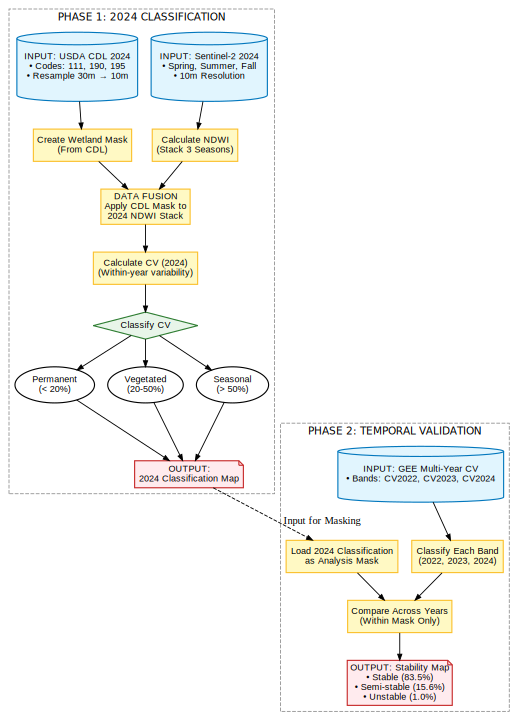

File saved as 'wetland_workflow.png'. Check your Colab 'Files' tab to download.


In [ ]:
import graphviz
from IPython.display import display

# Create the Directed Graph
dot = graphviz.Digraph('Data_Sources_Workflow', comment='Wetland Classification Workflow')

# --- GLOBAL STYLES ---
dot.attr(rankdir='TB', size='10')
dot.attr('node', fontname='Arial', fontsize='12', shape='rect', style='filled', penwidth='1.5')
dot.attr('edge', arrowsize='0.8', penwidth='1.2')

# Define specific visual styles for Node Types
# Colors: Blue (Input), Yellow (Process), Green (Decision), Red/Pink (Output)
input_style = {'shape': 'cylinder', 'fillcolor': '#E1F5FE', 'color': '#0277BD', 'margin': '0.2'}
process_style = {'shape': 'box', 'fillcolor': '#FFF9C4', 'color': '#FBC02D', 'height': '0.6'}
decision_style = {'shape': 'diamond', 'fillcolor': '#E8F5E9', 'color': '#2E7D32'}
output_style = {'shape': 'note', 'fillcolor': '#FFEBEE', 'color': '#C62828'}

# --- PHASE 1: 2024 CLASSIFICATION ---
with dot.subgraph(name='cluster_phase1') as c:
    c.attr(label='PHASE 1: 2024 CLASSIFICATION', style='dashed', color='grey', fontname='Arial-Bold')

    # Nodes
    c.node('S2', 'INPUT: Sentinel-2 2024\n• Spring, Summer, Fall\n• 10m Resolution', **input_style)
    c.node('CDL', 'INPUT: USDA CDL 2024\n• Codes: 111, 190, 195\n• Resample 30m → 10m', **input_style)

    c.node('NDWI', 'Calculate NDWI\n(Stack 3 Seasons)', **process_style)
    c.node('Mask', 'Create Wetland Mask\n(From CDL)', **process_style)
    c.node('Fusion', 'DATA FUSION\nApply CDL Mask to\n2024 NDWI Stack', **process_style)
    c.node('CalcCV', 'Calculate CV (2024)\n(Within-year variability)', **process_style)

    c.node('Classify', 'Classify CV', **decision_style)

    c.node('Perm', 'Permanent\n(< 20%)', shape='ellipse', style='filled', fillcolor='white')
    c.node('Veg', 'Vegetated\n(20-50%)', shape='ellipse', style='filled', fillcolor='white')
    c.node('Seas', 'Seasonal\n(> 50%)', shape='ellipse', style='filled', fillcolor='white')

    c.node('Result24', 'OUTPUT:\n2024 Classification Map', **output_style)

    # Edges
    c.edge('S2', 'NDWI')
    c.edge('CDL', 'Mask')
    c.edge('NDWI', 'Fusion')
    c.edge('Mask', 'Fusion')
    c.edge('Fusion', 'CalcCV')
    c.edge('CalcCV', 'Classify')

    # Decision branches
    c.edge('Classify', 'Perm')
    c.edge('Classify', 'Veg')
    c.edge('Classify', 'Seas')

    c.edge('Perm', 'Result24')
    c.edge('Veg', 'Result24')
    c.edge('Seas', 'Result24')

# --- PHASE 2: TEMPORAL VALIDATION ---
with dot.subgraph(name='cluster_phase2') as c:
    c.attr(label='PHASE 2: TEMPORAL VALIDATION', style='dashed', color='grey', fontname='Arial-Bold')

    # Nodes
    c.node('GEE', 'INPUT: GEE Multi-Year CV\n• Bands: CV2022, CV2023, CV2024', **input_style)
    c.node('ClassBands', 'Classify Each Band\n(2022, 2023, 2024)', **process_style)
    c.node('LoadMask', 'Load 2024 Classification\n as Analysis Mask', **process_style)
    c.node('Compare', 'Compare Across Years\n(Within Mask Only)', **process_style)
    c.node('Stability', 'OUTPUT: Stability Map\n• Stable (83.5%)\n• Semi-stable (15.6%)\n• Unstable (1.0%)', **output_style)

    # Edges
    c.edge('GEE', 'ClassBands')
    c.edge('LoadMask', 'Compare')
    c.edge('ClassBands', 'Compare')
    c.edge('Compare', 'Stability')

# --- CONNECT PHASES ---
# Dashed line showing the 2024 map feeds into Phase 2
dot.edge('Result24', 'LoadMask', style='dashed', label=' Input for Masking')

# --- RENDER AND DOWNLOAD ---
# Render inline
display(dot)

# Save to file (PNG and PDF)
dot.render('wetland_workflow', format='png', cleanup=True)
print("File saved as 'wetland_workflow.png'. Check your Colab 'Files' tab to download.")

In [ ]:
import graphviz
from IPython.display import display

# Create the Directed Graph
dot = graphviz.Digraph('Data_Sources_Workflow', comment='Wetland Classification Workflow')

# --- FIX 1: INCREASE RESOLUTION ---
# 'dpi': '300' makes it high quality for print/Word/LaTeX
# 'size': '10' ensures it doesn't get shrunk down too much
dot.attr(dpi='300', rankdir='TB', size='10')

# --- GLOBAL STYLES ---
dot.attr('node', fontname='Arial', fontsize='12', shape='rect', style='filled', penwidth='1.5')
dot.attr('edge', arrowsize='0.8', penwidth='1.2')

# Define specific visual styles for Node Types
input_style = {'shape': 'cylinder', 'fillcolor': '#E1F5FE', 'color': '#0277BD', 'margin': '0.2'}
process_style = {'shape': 'box', 'fillcolor': '#FFF9C4', 'color': '#FBC02D', 'height': '0.6'}
decision_style = {'shape': 'diamond', 'fillcolor': '#E8F5E9', 'color': '#2E7D32'}
output_style = {'shape': 'note', 'fillcolor': '#FFEBEE', 'color': '#C62828'}

# --- PHASE 1: 2024 CLASSIFICATION ---
with dot.subgraph(name='cluster_phase1') as c:
    c.attr(label='PHASE 1: 2024 CLASSIFICATION', style='dashed', color='grey', fontname='Arial-Bold')
    c.node('S2', 'INPUT: Sentinel-2 2024\n• Spring, Summer, Fall\n• 10m Resolution', **input_style)
    c.node('CDL', 'INPUT: USDA CDL 2024\n• Codes: 111, 190, 195\n• Resample 30m → 10m', **input_style)
    c.node('NDWI', 'Calculate NDWI\n(Stack 3 Seasons)', **process_style)
    c.node('Mask', 'Create Wetland Mask\n(From CDL)', **process_style)
    c.node('Fusion', 'DATA FUSION\nApply CDL Mask to\n2024 NDWI Stack', **process_style)
    c.node('CalcCV', 'Calculate CV (2024)\n(Within-year variability)', **process_style)
    c.node('Classify', 'Classify CV', **decision_style)
    c.node('Perm', 'Permanent\n(< 20%)', shape='ellipse', style='filled', fillcolor='white')
    c.node('Veg', 'Vegetated\n(20-50%)', shape='ellipse', style='filled', fillcolor='white')
    c.node('Seas', 'Seasonal\n(> 50%)', shape='ellipse', style='filled', fillcolor='white')
    c.node('Result24', 'OUTPUT:\n2024 Classification Map', **output_style)

    c.edge('S2', 'NDWI')
    c.edge('CDL', 'Mask')
    c.edge('NDWI', 'Fusion')
    c.edge('Mask', 'Fusion')
    c.edge('Fusion', 'CalcCV')
    c.edge('CalcCV', 'Classify')
    c.edge('Classify', 'Perm')
    c.edge('Classify', 'Veg')
    c.edge('Classify', 'Seas')
    c.edge('Perm', 'Result24')
    c.edge('Veg', 'Result24')
    c.edge('Seas', 'Result24')

# --- PHASE 2: TEMPORAL VALIDATION ---
with dot.subgraph(name='cluster_phase2') as c:
    c.attr(label='PHASE 2: TEMPORAL VALIDATION', style='dashed', color='grey', fontname='Arial-Bold')
    c.node('GEE', 'INPUT: GEE Multi-Year CV\n• Bands: CV2022, CV2023, CV2024', **input_style)
    c.node('ClassBands', 'Classify Each Band\n(2022, 2023, 2024)', **process_style)
    c.node('LoadMask', 'Load 2024 Classification\n as Analysis Mask', **process_style)
    c.node('Compare', 'Compare Across Years\n(Within Mask Only)', **process_style)
    c.node('Stability', 'OUTPUT: Stability Map\n• Stable (83.5%)\n• Semi-stable (15.6%)\n• Unstable (1.0%)', **output_style)

    c.edge('GEE', 'ClassBands')
    c.edge('LoadMask', 'Compare')
    c.edge('ClassBands', 'Compare')
    c.edge('Compare', 'Stability')

# --- CONNECT PHASES ---
dot.edge('Result24', 'LoadMask', style='dashed', label=' Input for Masking')

# --- FIX 2: EXPORT AS PDF & HIGH RES PNG ---
# Render as PDF (Best for Papers/Zooming)
dot.render('wetland_workflow', format='pdf', cleanup=True)

# Render as High-Res PNG
dot.render('wetland_workflow_high_res', format='png', cleanup=True)

print("Files generated!")
print("1. 'wetland_workflow.pdf' (Best for documents)")
print("2. 'wetland_workflow_high_res.png' (High quality image)")

Files generated!
1. 'wetland_workflow.pdf' (Best for documents)
2. 'wetland_workflow_high_res.png' (High quality image)
